In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd /content/drive/My Drive/Colab Notebooks/

/content/drive/My Drive/Colab Notebooks


#Load Images

In [6]:
images = np.load('pathmnist.npz')

In [7]:
x_train = images['train_images']
x_test = images['test_images']
y_train = images['train_labels']
y_test = images['test_labels']

In [8]:
x_train.shape

(89996, 28, 28, 3)

In [9]:
y_train.shape

(89996, 1)

In [10]:
x_train.max()

255

In [11]:
y_train.max()

8

#Preprocess Data

In [12]:
x_train = x_train/255
x_test = x_test/255

In [13]:
from tensorflow.keras.utils import to_categorical

In [14]:
#one hot encoding
y_cat_train = to_categorical(y_train)

In [15]:
y_cat_test = to_categorical(y_test)

In [16]:
y_cat_train.shape

(89996, 9)

In [17]:
y_cat_test.shape

(7180, 9)

#Build Model

In [18]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dense
from tensorflow.keras.layers import AvgPool2D, GlobalAveragePooling2D, MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import ReLU, concatenate
import tensorflow.keras.backend as K

In [19]:
shape = 28, 28, 3
num_classes = 9
filters = 32

# Batch normalization, ReLU, and 2D conversion function
def ConvolutionalBlock(x, filters, kernel=1, strides=1):
  x = BatchNormalization()(x)
  x = ReLU()(x)
  x = Conv2D(filters, kernel, strides=strides, padding = 'same')(x)

  return x

def DenseBlock(x, num_repeats):
  for _ in range(num_repeats):
    y = ConvolutionalBlock(x, 4*filters)
    y = ConvolutionalBlock(y, filters, 3)
    x = concatenate([y, x])
  return x

def TransitionLayer(x):
  x = ConvolutionalBlock(x, K.int_shape(x)[-1] //2)
  x = AvgPool2D(2, strides=2, padding='same')(x)
  return x

input = Input(shape)
x = Conv2D(64, 7, strides=2, padding='same')(input)
x = MaxPool2D(3, strides=2, padding='same')(x)

for num_repeats in [6, 12, 24, 16]:
  d = DenseBlock(x, num_repeats)
  x = TransitionLayer(d)

x = GlobalAveragePooling2D()(d)
out = Dense(num_classes, activation='softmax')(x)
model = Model(input, out)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 64)   9472        ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 7, 7, 64)     0           ['conv2d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 7, 7, 64)    256         ['max_pooling2d[0][0]']          
 alization)                                                                                   

#Train Model

In [20]:
from tensorflow.keras.callbacks import EarlyStopping

In [21]:
early_stop = EarlyStopping(monitor='val_loss', patience=20)

In [22]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-05)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
model.fit(x_train, y_cat_train, epochs=50, validation_data=(x_test, y_cat_test), batch_size=128, callbacks=[early_stop])

Epoch 1/50
704/704 [==============================] - 151s 172ms/step - loss: 1.2454 - accuracy: 0.5546 - val_loss: 1.1526 - val_accuracy: 0.6148
Epoch 2/50
704/704 [==============================] - 114s 162ms/step - loss: 0.8720 - accuracy: 0.6806 - val_loss: 0.9956 - val_accuracy: 0.6795
Epoch 3/50
704/704 [==============================] - 114s 163ms/step - loss: 0.7512 - accuracy: 0.7245 - val_loss: 0.9854 - val_accuracy: 0.6731
Epoch 4/50
704/704 [==============================] - 114s 163ms/step - loss: 0.6763 - accuracy: 0.7520 - val_loss: 0.8389 - val_accuracy: 0.7478
Epoch 5/50
704/704 [==============================] - 114s 162ms/step - loss: 0.6177 - accuracy: 0.7734 - val_loss: 0.8989 - val_accuracy: 0.7248
Epoch 6/50
704/704 [==============================] - 114s 162ms/step - loss: 0.5693 - accuracy: 0.7921 - val_loss: 0.8475 - val_accuracy: 0.7425
Epoch 7/50
704/704 [==============================] - 114s 163ms/step - loss: 0.5255 - accuracy: 0.8086 - val_loss: 0.9411 -

In [24]:
metrics = pd.DataFrame(model.history.history)

In [25]:
metrics

,loss,accuracy,val_loss,val_accuracy
0,1.245353,0.554558,1.152616,0.614763
1,0.872044,0.680630,0.995564,0.679526
2,0.751214,0.724543,0.985362,0.673120
3,0.676254,0.752000,0.838867,0.747772
4,0.617745,0.773368,0.898943,0.724791
5,0.569333,0.792113,0.847534,0.742479
6,0.525475,0.808580,0.941108,0.712813
7,0.490391,0.821225,0.885941,0.737604
8,0.452482,0.835470,1.011033,0.709192
9,0.415554,0.850871,0.956303,0.722423


In [26]:
metrics.columns

Index(['loss', 'accuracy', 'val_loss', 'val_accuracy'], dtype='object')

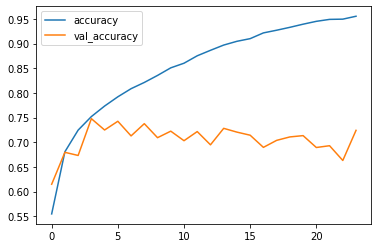

In [27]:
metrics[['accuracy', 'val_accuracy']].plot()

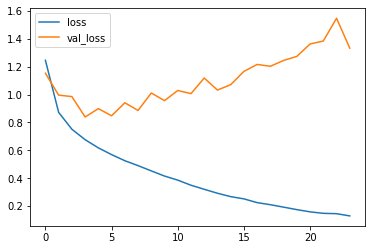

In [28]:
metrics[['loss', 'val_loss']].plot()

In [29]:
from sklearn.metrics import classification_report, confusion_matrix

In [30]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred,axis=1)

In [31]:
y_pred

array([8, 4, 0, ..., 4, 8, 8])

In [32]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91      1330
           1       1.00      0.82      0.90      1033
           2       0.70      0.36      0.48       652
           3       0.65      0.76      0.70       545
           4       0.72      0.80      0.76       925
           5       0.48      0.69      0.57       416
           6       0.56      0.59      0.57       714
           7       0.33      0.43      0.37       316
           8       0.73      0.73      0.73      1249

    accuracy                           0.72      7180
   macro avg       0.68      0.68      0.67      7180
weighted avg       0.74      0.72      0.73      7180



In [33]:
print(confusion_matrix(y_pred, y_test))

[[1212    0    0   36   61    0   19    0    2]
 [  23  846    0    0  159    0    1    0    4]
 [  25    0  237   36    1  100   47  105  101]
 [   0    0    9  413    3   57   29   16   18]
 [  43    0    1   12  743    3   68   20   35]
 [  19    0   46    2    1  287    4   50    7]
 [   3    0    0  108   15    1  418   20  149]
 [   0    0   31    1    3  124    9  137   11]
 [  13    1   15   26   49   20  146   73  906]]
